In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from torchvision.models import resnet50
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# dataset stats
train_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/train'
test_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/test'
valid_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/valid'

train_data_count = []
test_data_count = []
valid_data_count = []

class_name = os.listdir(train_data_path)
class_name.sort()

# train data stats
for i in class_name:
    train_data_count.append(len(os.listdir(train_data_path + '/' + i)))
    test_data_count.append(len(os.listdir(test_data_path + '/' + i)))
    valid_data_count.append(len(os.listdir(valid_data_path + '/' + i)))

# print dataset statistics in table format
print(f"{'Class Name':<20} {'Train Count':<12} {'Test Count':<12} {'Valid Count':<12}")
print("=" * 60)

train_total = test_total = valid_total = 0
for i in range(len(class_name)):
    train_total += train_data_count[i]
    test_total += test_data_count[i]
    valid_total += valid_data_count[i]
    print(f"{class_name[i]:<20} {train_data_count[i]:<12} {test_data_count[i]:<12} {valid_data_count[i]:<12}")

print("=" * 60)
print(f"{'TOTAL':<20} {train_total:<12} {test_total:<12} {valid_total:<12}")
    

Class Name           Train Count  Test Count   Valid Count 
ALABAMA              157          5            5           
ALASKA               149          5            5           
AMERICAN SAMOA       143          5            5           
ARIZONA              139          5            5           
ARKANSAS             169          5            5           
CALIFORNIA           154          5            5           
CNMI                 86           5            5           
COLORADO             133          5            5           
CONNECTICUT          143          5            5           
DELAWARE             141          5            5           
FLORIDA              149          5            5           
GEORGIA              136          5            5           
GUAM                 162          5            5           
HAWAI                144          5            5           
IDAHO                144          5            5           
ILLINOIS             144          5     

In [5]:
print(class_name)

data_path = '/kaggle/input/us-license-plates-image-classification/new plates'
csv_path = data_path + "/plates.csv"

df = pd.read_csv(csv_path)  # Read the CSV file into a pandas DataFrame
print(df.head())  # Print the first few rows

['ALABAMA', 'ALASKA', 'AMERICAN SAMOA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'CNMI', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'GUAM', 'HAWAI', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'PUERTO RICO', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'U S VIRGIN ISLANDS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WASHINGTON DC', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']
   class id              filepaths   labels data set
0         0  train/ALABAMA/001.jpg  ALABAMA    train
1         0  train/ALABAMA/002.jpg  ALABAMA    train
2         0  train/ALABAMA/003.jpg  ALABAMA    train
3         0  train/ALABAMA/004.jpg  ALABAMA    train
4         0  train/ALABAMA/0

In [ ]:
class CustomDataset(Dataset):
    # 0001.jpg, 0
    # 0001.jpg, [1,0,0,0,0,0,0, ...]
    def __init__(self, image_paths, labels, transform = False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # 1 hot encoding setup
        label_idx = self.labels[idx]
        label = torch.zeros(56)
        label[label_idx] = 1

        # Load the image
        image = Image.open('/kaggle/input/us-license-plates-image-classification/new plates/'+image_path)


        # transformations approaches

        # approach 0: centercrop to 224x224 (losign left and right side of the image)
        # transform = transforms.Compose([
        #     transforms.Resize(224),
        #     transforms.CenterCrop(224),
        #     transforms.ToTensor()
        # ])
        # used for Baseline/Midterm Report

        # approach 1: stretch the image to fit 224x224 (does not lose any info)
        # transform = transforms.Compose([
        #     transforms.Resize((224,224)),
        #     transforms.ToTensor()
        # ])
        # Used for A1,7

        # approach 2: augment data for training to introduce more variance in images
        # transform = None
        # if self.transform:
        #     # introducing variance in brightness, contrast, degrees (tilt), etc
        #     transform = transforms.Compose([
        #         transforms.Resize((224, 224)),
        #         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        #         transforms.RandomAffine(
        #             degrees=7,              # (±7°)
        #             translate=(0.05, 0.05), # up to 5% translation
        #             scale=(0.95, 1.05),     # 95%-105% zoom
        #             shear=3                 # small shear
        #         ),
        #         transforms.ToTensor(),
        #         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #     ])
        # else:
        #     # same as approach 1 but with Normalization
        #     transform = transforms.Compose([
        #         transforms.Resize((224, 224)),
        #         transforms.ToTensor(),
        #         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #     ])
        # only augmentation (approach 3)
        # but def could have gotten higher if we ran 5 more epochs (30). it was still on the rise
        # Used for A2,3,4,5,6

        # approach 3 (approach 2 but less)
        transform = None
        if self.transform:
            # introducing variance in brightness, contrast, degrees (tilt), etc
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
                transforms.RandomAffine(
                    degrees=5,              # (±5°)
                    translate=(0.03, 0.03), # up to 3% translation
                    scale=(0.97, 1.03),     # 97%-103% zoom
                    shear=2                 # small shear
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            # same as approach 1 but with Normalization
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        # Used for A8


        # Apply transformations
        tensor_image = transform(image)

        return tensor_image, label, image_path

In [7]:
df_train = df[df["data set"] == "train"][["filepaths", "class id"]]
train_data = CustomDataset(df_train["filepaths"], df_train["class id"], transform= True)

df_test = df[df["data set"] == "test"][["filepaths", "class id"]].reset_index(drop=True)
test_data = CustomDataset(df_test["filepaths"], df_test["class id"])

df_valid = df[df["data set"] == "valid"][["filepaths", "class id"]].reset_index(drop=True)
valid_data = CustomDataset(df_valid["filepaths"], df_valid["class id"])

# print a sample image
print(train_data.__getitem__(0))
print(test_data.__getitem__(0))
print(valid_data.__getitem__(0))

dl_train = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_test = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_valid = DataLoader(valid_data, batch_size=1, shuffle=True, pin_memory = True, num_workers=4)

print(f'train images count: {len(train_data)}')
print(f'test images count: {len(test_data)}')
print(f'valid images count: {len(valid_data)}')

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ...,  0.6906,  0.7077, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ...,  0.7419,  0.7248, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ...,  0.7419,  0.7248, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ...,  0.7829,  0.8004, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ...,  0.8704,  0.8529, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ...,  0.8704,  0.8529, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

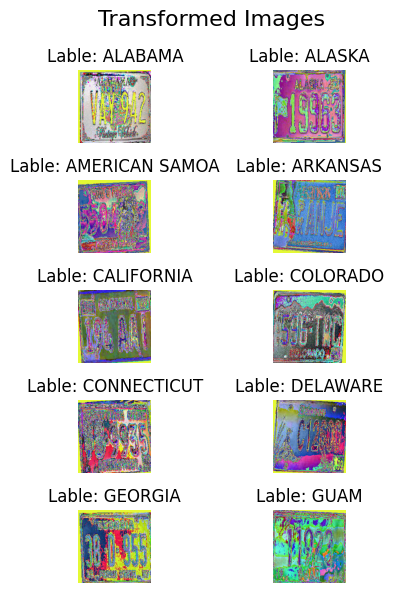

In [8]:
# Display transformed iamges
fig, axes = plt.subplots(5, 2, figsize=(5,6))

fig.suptitle("Transformed Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < 10:
        tensor_image, label, image_path = train_data.__getitem__(i*200)
        img = to_pil_image(tensor_image.squeeze(0))
        ax.imshow(img)
        ax.set_title(f"Lable: {class_name[label.argmax(dim=-1).item()]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device", device)

# initialize resnet50 model
model = resnet50()
# Linear transformation from 2048-56
# Used for A1,2,3,4,8
model.fc = torch.nn.Linear(2048, 56)

# Custom FC final layer
# Used for A 5,6,7
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(2048, 512),
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.5),
#     torch.nn.Linear(512, 56)
# )

# layer freezing
# Used for A5
# for name, param in model.named_parameters():
#     if not any([name.startswith("layer3"), name.startswith("layer4"), name.startswith("fc")]):
#         param.requires_grad = False
# Used for A6
# for name, param in model.named_parameters():
#     if not any([name.startswith("layer2"), name.startswith("layer3"), name.startswith("layer4"), name.startswith("fc")]):
#         param.requires_grad = False

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

model.to(device)

device cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
# 0.001 learning rate
# Used for A 1,2,3,4,7,8
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 0.0001 learning rate
# Used for A6
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 0.0001 learning rate for layer 3 and 4, 0.001 learning rate for fc
# Used for A5
# optimizer = torch.optim.Adam([
#     {"params": model.layer3.parameters(), "lr": 1e-4},
#     {"params": model.layer4.parameters(), "lr": 1e-4},
#     {"params": model.fc.parameters(), "lr": 1e-3}
# ])

def train_one_epoch(dataloader):
  # use tqdm for for loop
  progress = tqdm(dataloader)
  total_loss = 0
  total_correct = 0
  total_sample = 0

  for i, data in enumerate(progress):
    # extract data and label
    tensor_image, label, image_label = data

    # move data to the same device as the model
    tensor_image = tensor_image.to(device)
    label = label.to(device)

    # clear optimizer
    optimizer.zero_grad()

    # get the prediction from the current model
    output = model(tensor_image)

    # convert label from long to float (for BCE loss func)
    label = label.float()

    # calculate the loss
    loss = loss_fn(output, label)
    loss.backward()

    # update the weights of the model
    optimizer.step()

    # update total_loss value
    total_loss += loss.item()

    true_classes = label.argmax(dim=1)
    # compute accuracy for the batch
    predicted_classes = output.argmax(dim=1)
    batch_correct = (predicted_classes == true_classes).sum().item()
    total_correct += batch_correct
    total_sample += label.shape[0]

    # add description to progress bar
    progress.set_description(f"batch: {i+1} | loss:{loss.item()}")

  avg_loss = total_loss / len(dataloader)
  train_accuracy = total_correct * 100 / total_sample
  return avg_loss, train_accuracy  # Return average loss over all batches

In [11]:
def evaluate(dataloader):
    # use tqdm for for loop
    progress = tqdm(dataloader)
    total_loss = 0
    total_correct = 0
    total_sample = 0
    with torch.no_grad():
        for i, data in enumerate(progress):
            tensor_image, label, image_label = data
            # print(label.shape) # torch.Size([32, 56])
            
            # move data to the same device as the model
            tensor_image = tensor_image.to(device)
            label = label.to(device)

            output = model(tensor_image)
            true_classes = label.argmax(dim=1) 
            predicted_classes = output.argmax(dim=1) # shape: [32] w all max index
            # print(true_classes.shape, predicted_classes.shape) # torch.Size([32, 56])

            batch_correct = (predicted_classes == true_classes).sum().item()
            total_correct += batch_correct
            total_sample += label.shape[0]

            # Compute loss
            total_loss += loss_fn(output, label).item()

    avg_loss = total_loss / len(dl_test)
    accuracy = total_correct*100/total_sample
    # print(f"accuracy: {total_correct*100/total_sample}%")
    return avg_loss, accuracy


In [12]:
# training
EPOCHS = 40

avg_loss_log = []
train_accuracy_log = []
avg_test_loss_log = []
test_accuracy_log = []

best_test_avg_loss = float('inf')
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(EPOCHS):
    model.train()
    print("EPOCH:", epoch)
    avg_loss, train_accuracy = train_one_epoch(dl_train)
    print("avg loss:", avg_loss)
    avg_loss_log.append(avg_loss)
    train_accuracy_log.append(train_accuracy)

    model.eval()
    test_avg_loss, test_accuracy = evaluate(dl_test)
    print(f"avg test loss: {test_avg_loss}")
    print(f"train accuracy: {train_accuracy}%")
    print(f"test accuracy: {test_accuracy}%")
    
    avg_test_loss_log.append(test_avg_loss)
    test_accuracy_log.append(test_accuracy)

    if test_avg_loss < best_test_avg_loss:
        best_test_avg_loss = test_avg_loss
        torch.save(model.state_dict(), best_model_path)
    
    print()

EPOCH: 0


batch: 256 | loss:0.11665625125169754: 100%|██████████| 256/256 [00:45<00:00,  5.60it/s]


avg loss: 0.0956911965913605


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


avg test loss: 0.09812727487749523
train accuracy: 4.264183310868766%
test accuracy: 2.857142857142857%

EPOCH: 1


batch: 256 | loss:0.12341064214706421: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]


avg loss: 0.08628197276266292


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


avg test loss: 0.09094946500327852
train accuracy: 8.344565616958706%
test accuracy: 10.357142857142858%

EPOCH: 2


batch: 256 | loss:0.09778760373592377: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]


avg loss: 0.08106221730122343


100%|██████████| 9/9 [00:00<00:00, 12.05it/s]


avg test loss: 0.11727230168051189
train accuracy: 14.54478617816444%
test accuracy: 12.5%

EPOCH: 3


batch: 256 | loss:0.18950702250003815: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s] 


avg loss: 0.07399889006046578


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


avg test loss: 0.1539274619685279
train accuracy: 23.56328881264551%
test accuracy: 18.571428571428573%

EPOCH: 4


batch: 256 | loss:0.1225404441356659: 100%|██████████| 256/256 [00:44<00:00,  5.80it/s]  


avg loss: 0.07022517193399835


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


avg test loss: 0.06873048717776935
train accuracy: 28.08479353020463%
test accuracy: 30.714285714285715%

EPOCH: 5


batch: 256 | loss:0.17176523804664612: 100%|██████████| 256/256 [00:44<00:00,  5.78it/s] 


avg loss: 0.062223435976193286


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


avg test loss: 0.077161253326469
train accuracy: 38.57370420291631%
test accuracy: 20.0%

EPOCH: 6


batch: 256 | loss:0.16915160417556763: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s] 


avg loss: 0.063439482008107


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


avg test loss: 0.06040486817558607
train accuracy: 36.69893395417228%
test accuracy: 42.5%

EPOCH: 7


batch: 256 | loss:0.11178204417228699: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s] 


avg loss: 0.053402808131068014


100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


avg test loss: 0.05325595123900308
train accuracy: 47.469672834211494%
test accuracy: 49.285714285714285%

EPOCH: 8


batch: 256 | loss:0.13894861936569214: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s] 


avg loss: 0.04689343428617576


100%|██████████| 9/9 [00:00<00:00, 11.87it/s]


avg test loss: 0.049176189220613904
train accuracy: 55.360862639382425%
test accuracy: 49.285714285714285%

EPOCH: 9


batch: 256 | loss:0.12895816564559937: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s] 


avg loss: 0.04146876277081901


100%|██████████| 9/9 [00:00<00:00, 11.95it/s]


avg test loss: 0.04101839785774549
train accuracy: 61.58559000122534%
test accuracy: 62.857142857142854%

EPOCH: 10


batch: 256 | loss:0.15751813352108002: 100%|██████████| 256/256 [00:44<00:00,  5.79it/s] 


avg loss: 0.0360240541776875


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


avg test loss: 0.04392582757605447
train accuracy: 66.805538536944%
test accuracy: 62.857142857142854%

EPOCH: 11


batch: 256 | loss:0.1592930257320404: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]  


avg loss: 0.03142072883201763


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


avg test loss: 0.0502600914074315
train accuracy: 72.12351427521138%
test accuracy: 61.07142857142857%

EPOCH: 12


batch: 256 | loss:0.18580693006515503: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s] 


avg loss: 0.02830778102725162


100%|██████████| 9/9 [00:00<00:00, 11.70it/s]


avg test loss: 0.036765230198701225
train accuracy: 75.66474696728342%
test accuracy: 65.71428571428571%

EPOCH: 13


batch: 256 | loss:0.15376988053321838: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s] 


avg loss: 0.022862357644044096


100%|██████████| 9/9 [00:00<00:00, 12.06it/s]


avg test loss: 0.03739762388997608
train accuracy: 81.42384511701998%
test accuracy: 66.07142857142857%

EPOCH: 14


batch: 256 | loss:0.21151714026927948: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s] 


avg loss: 0.020080287824384868


100%|██████████| 9/9 [00:00<00:00, 11.81it/s]


avg test loss: 0.02765925932261679
train accuracy: 84.40142139443695%
test accuracy: 78.92857142857143%

EPOCH: 15


batch: 256 | loss:0.228589728474617: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]   


avg loss: 0.017168426918942714


100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


avg test loss: 0.033068562754326396
train accuracy: 86.92562186006617%
test accuracy: 76.42857142857143%

EPOCH: 16


batch: 256 | loss:0.219012051820755: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]    


avg loss: 0.014934839322449989


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


avg test loss: 0.022829982452094555
train accuracy: 89.42531552505821%
test accuracy: 82.85714285714286%

EPOCH: 17


batch: 256 | loss:0.23539310693740845: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]  


avg loss: 0.012984988641619566


100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


avg test loss: 0.01824841524163882
train accuracy: 90.83445656169587%
test accuracy: 86.42857142857143%

EPOCH: 18


batch: 256 | loss:0.25252410769462585: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]  


avg loss: 0.011509042280522408


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


avg test loss: 0.01871331212007337
train accuracy: 92.72148021075849%
test accuracy: 84.64285714285714%

EPOCH: 19


batch: 256 | loss:0.20918230712413788: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]  


avg loss: 0.009661820752626227


100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


avg test loss: 0.013687169903682338
train accuracy: 94.35118245313075%
test accuracy: 89.28571428571429%

EPOCH: 20


batch: 256 | loss:0.30000054836273193: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]  


avg loss: 0.009567668927047634


100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


avg test loss: 0.016027315519750118
train accuracy: 94.66977086141404%
test accuracy: 87.5%

EPOCH: 21


batch: 256 | loss:0.3080189824104309: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]   


avg loss: 0.008401909127769613


100%|██████████| 9/9 [00:00<00:00, 12.08it/s]


avg test loss: 0.014980253039134873
train accuracy: 95.36821467957358%
test accuracy: 89.28571428571429%

EPOCH: 22


batch: 256 | loss:0.2862790524959564: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]   


avg loss: 0.007492774961065152


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


avg test loss: 0.01237423164356086
train accuracy: 95.76032348976841%
test accuracy: 91.42857142857143%

EPOCH: 23


batch: 256 | loss:0.2995785176753998: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]   


avg loss: 0.007238659784889023


100%|██████████| 9/9 [00:00<00:00, 11.41it/s]


avg test loss: 0.014681261084559891
train accuracy: 96.16468570028182%
test accuracy: 89.28571428571429%

EPOCH: 24


batch: 256 | loss:0.24601133167743683: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]  


avg loss: 0.006339119137919624


100%|██████████| 9/9 [00:00<00:00, 12.19it/s]


avg test loss: 0.0120601047658258
train accuracy: 97.0346771229016%
test accuracy: 92.5%

EPOCH: 25


batch: 256 | loss:0.2828459143638611: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]   


avg loss: 0.005990806818772398


100%|██████████| 9/9 [00:00<00:00, 12.32it/s]


avg test loss: 0.009450841513979766
train accuracy: 97.18171792672467%
test accuracy: 93.21428571428571%

EPOCH: 26


batch: 256 | loss:0.26705849170684814: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]  


avg loss: 0.005038409954067902


100%|██████████| 9/9 [00:00<00:00, 12.17it/s]


avg test loss: 0.011686075220091475
train accuracy: 97.86790834456562%
test accuracy: 91.78571428571429%

EPOCH: 27


batch: 256 | loss:0.2263038605451584: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]   


avg loss: 0.005319894804870273


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


avg test loss: 0.013688878259725042
train accuracy: 97.85565494424704%
test accuracy: 91.78571428571429%

EPOCH: 28


batch: 256 | loss:0.2612372636795044: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]    


avg loss: 0.004737007907579027


100%|██████████| 9/9 [00:00<00:00, 12.22it/s]


avg test loss: 0.008950873265146382
train accuracy: 98.01494914838868%
test accuracy: 93.21428571428571%

EPOCH: 29


batch: 256 | loss:0.3299698233604431: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]    


avg loss: 0.00534465775785975


100%|██████████| 9/9 [00:00<00:00, 12.08it/s]


avg test loss: 0.00929774827737775
train accuracy: 98.03945594902585%
test accuracy: 93.92857142857143%

EPOCH: 30


batch: 256 | loss:0.31092700362205505: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]  


avg loss: 0.005040482588242412


100%|██████████| 9/9 [00:00<00:00, 12.18it/s]


avg test loss: 0.008518063670231236
train accuracy: 98.07621614998162%
test accuracy: 95.71428571428571%

EPOCH: 31


batch: 256 | loss:0.25281888246536255: 100%|██████████| 256/256 [00:44<00:00,  5.80it/s]   


avg loss: 0.0037016012809658605


100%|██████████| 9/9 [00:00<00:00, 12.16it/s]


avg test loss: 0.006241282609860516
train accuracy: 98.88494057100846%
test accuracy: 96.42857142857143%

EPOCH: 32


batch: 256 | loss:0.28739234805107117: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]   


avg loss: 0.0043609154571413455


100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


avg test loss: 0.00788983760382204
train accuracy: 98.41931135890209%
test accuracy: 95.0%

EPOCH: 33


batch: 256 | loss:0.2659171223640442: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]    


avg loss: 0.0037945881081213884


100%|██████████| 9/9 [00:00<00:00, 11.86it/s]


avg test loss: 0.011763718444854021
train accuracy: 98.90944737164563%
test accuracy: 92.14285714285714%

EPOCH: 34


batch: 256 | loss:0.2766916751861572: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]    


avg loss: 0.004085113646738137


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]


avg test loss: 0.01893613404697842
train accuracy: 98.6153657639995%
test accuracy: 88.21428571428571%

EPOCH: 35


batch: 256 | loss:0.27805113792419434: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]   


avg loss: 0.003916427593367189


100%|██████████| 9/9 [00:00<00:00, 11.94it/s]


avg test loss: 0.007247678004205227
train accuracy: 98.7378997671854%
test accuracy: 96.07142857142857%

EPOCH: 36


batch: 256 | loss:0.317430317401886: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]     


avg loss: 0.0035366335464459553


100%|██████████| 9/9 [00:00<00:00, 12.21it/s]


avg test loss: 0.008491288172081113
train accuracy: 99.1545153780174%
test accuracy: 94.64285714285714%

EPOCH: 37


batch: 256 | loss:0.30212247371673584: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]  


avg loss: 0.005129634974764485


100%|██████████| 9/9 [00:00<00:00, 12.08it/s]


avg test loss: 0.00911821135216289
train accuracy: 97.96593554711433%
test accuracy: 95.0%

EPOCH: 38


batch: 256 | loss:0.33966943621635437: 100%|██████████| 256/256 [00:43<00:00,  5.83it/s]   


avg loss: 0.0036780686507427163


100%|██████████| 9/9 [00:00<00:00, 11.71it/s]


avg test loss: 0.00997438726739751
train accuracy: 98.99522117387575%
test accuracy: 94.64285714285714%

EPOCH: 39


batch: 256 | loss:0.26369285583496094: 100%|██████████| 256/256 [00:44<00:00,  5.80it/s]   


avg loss: 0.004484864147002554


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]

avg test loss: 0.012901312671601772
train accuracy: 98.13748315157456%
test accuracy: 91.42857142857143%



In [13]:
torch.save(model.state_dict(), best_model_path)

<ipython-input-14-e8903d7f007d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


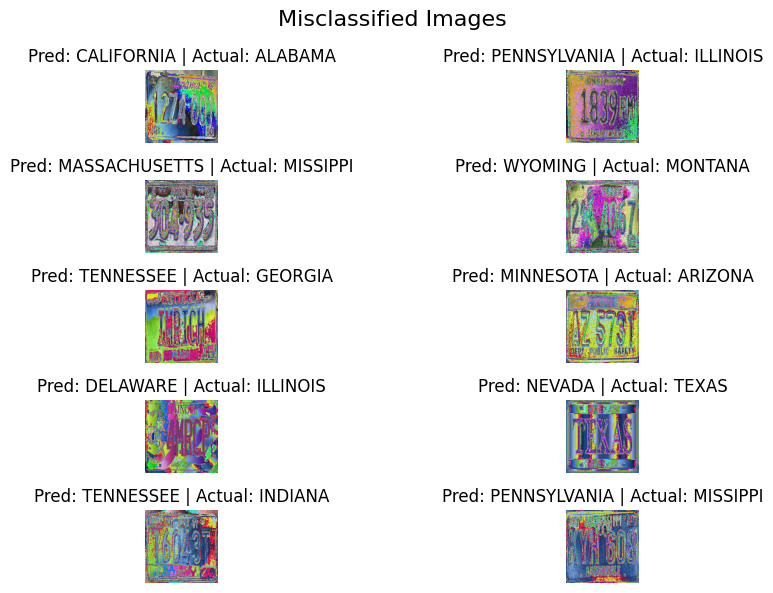

In [14]:
# see model's performance with validate datas
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

misclassified_images = []
misclassified_labels = []
misclassified_preds = []
misclassified_paths = []
all_preds = []
all_labels = []

with torch.no_grad():
    for data in dl_valid:
        tensor_image, label, image_path = data
        tensor_image = tensor_image.to(device)
        label = label.to(device)

        output = model(tensor_image)
        
        true_class = label.argmax(dim=1) 
        predicted_class = output.argmax(dim=1)

        all_preds.append(predicted_class.item())
        all_labels.append(true_class.item())

        if predicted_class != true_class: # wrong prediction
            misclassified_images.append(tensor_image.cpu())
            misclassified_labels.append(true_class.item())
            misclassified_preds.append(predicted_class.item())
            misclassified_paths.append(image_path[0])
            
# Display misclassified images
num_display = min(10, len(misclassified_images))  # Display up to 10 images
fig, axes = plt.subplots(5, 2, figsize=(12, 6))  # Create 2x5 grid

fig.suptitle("Misclassified Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < num_display:
        img = to_pil_image(misclassified_images[i].squeeze(0))  # Convert tensor to image
        ax.imshow(img)
        ax.set_title(f"Pred: {class_name[misclassified_preds[i]]} | Actual: {class_name[misclassified_labels[i]]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
print(f"Model accuracy: {100*(len(all_preds)-len(misclassified_preds))/len(all_preds)}%")
print("avg_loss_log", avg_loss_log)
print("avg_test_loss_log", avg_test_loss_log)
print("train_accuracy_log", train_accuracy_log)
print("test_accuracy_log", test_accuracy_log)

Model accuracy: 92.14285714285714%
avg_loss_log [0.0956911965913605, 0.08628197276266292, 0.08106221730122343, 0.07399889006046578, 0.07022517193399835, 0.062223435976193286, 0.063439482008107, 0.053402808131068014, 0.04689343428617576, 0.04146876277081901, 0.0360240541776875, 0.03142072883201763, 0.02830778102725162, 0.022862357644044096, 0.020080287824384868, 0.017168426918942714, 0.014934839322449989, 0.012984988641619566, 0.011509042280522408, 0.009661820752626227, 0.009567668927047634, 0.008401909127769613, 0.007492774961065152, 0.007238659784889023, 0.006339119137919624, 0.005990806818772398, 0.005038409954067902, 0.005319894804870273, 0.004737007907579027, 0.00534465775785975, 0.005040482588242412, 0.0037016012809658605, 0.0043609154571413455, 0.0037945881081213884, 0.004085113646738137, 0.003916427593367189, 0.0035366335464459553, 0.005129634974764485, 0.0036780686507427163, 0.004484864147002554]
avg_test_loss_log [0.09812727487749523, 0.09094946500327852, 0.11727230168051189, 

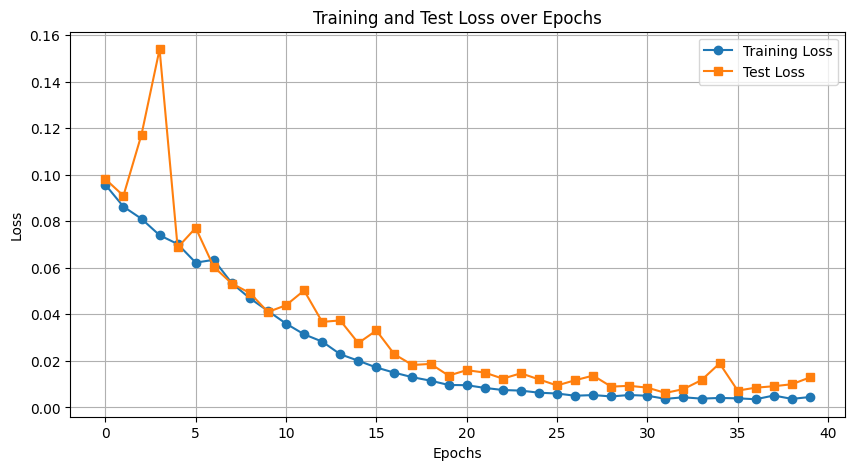

In [16]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(avg_loss_log, label='Training Loss', marker='o')
plt.plot(avg_test_loss_log, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

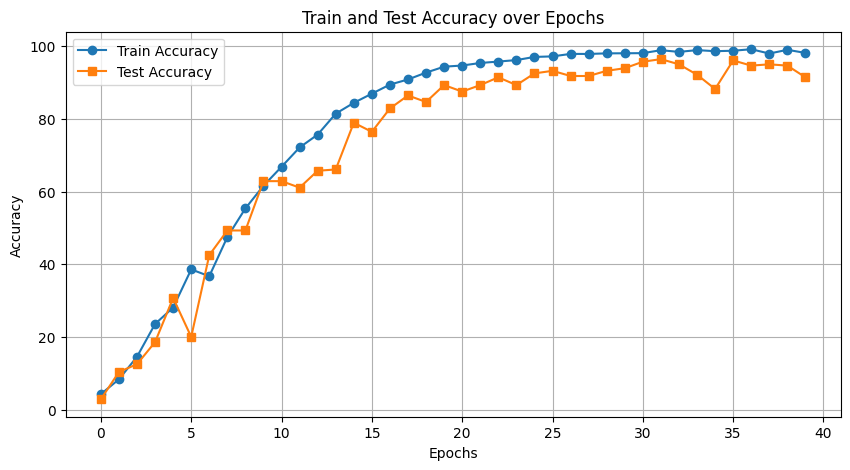

In [ ]:
# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_log, label='Train Accuracy', marker='o')
plt.plot(test_accuracy_log, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

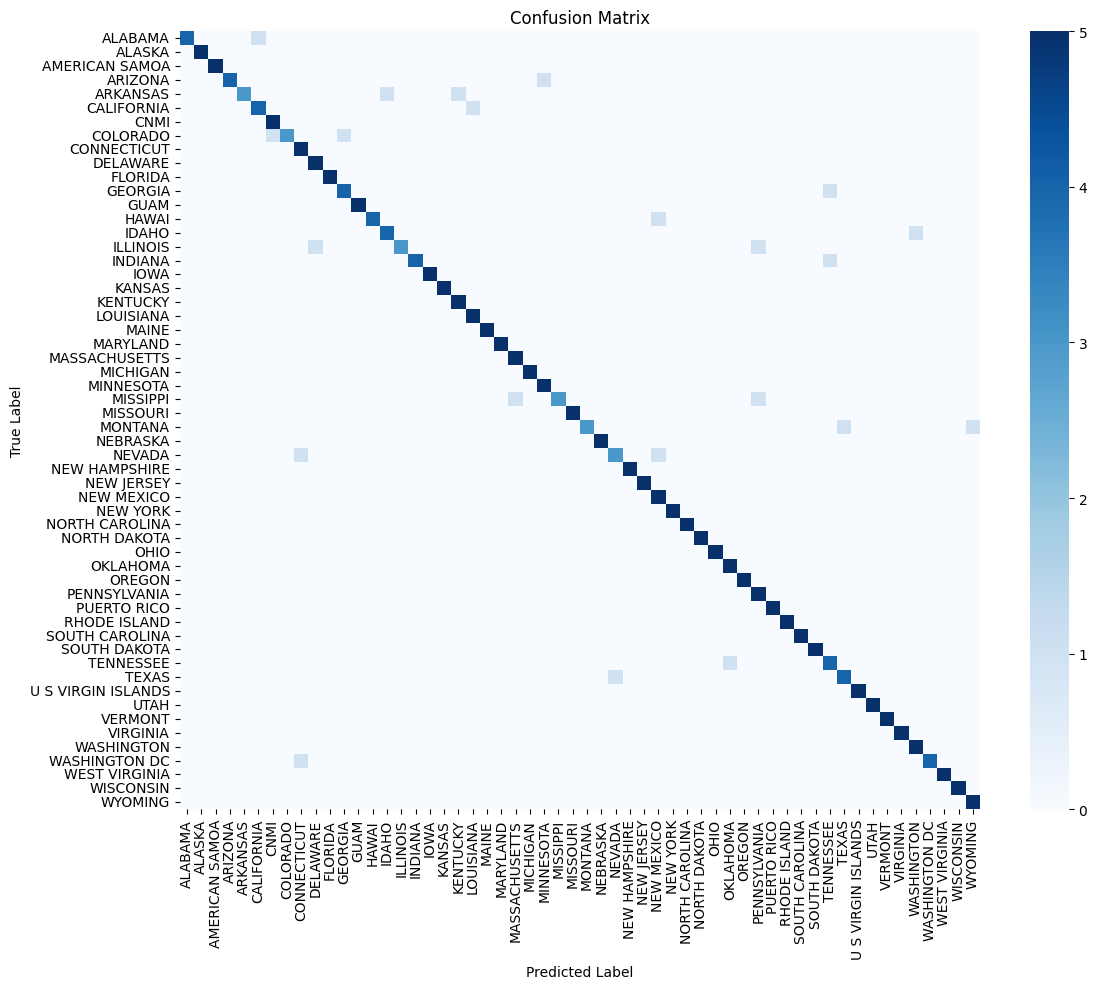

In [ ]:
# confusion matrix
label_names = class_name
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, ax=ax, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
correct_per_class = np.diag(cm)
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

# top 5 and bottom 5 classes
sorted_indices = np.argsort(accuracy_per_class)
print("Lowest 5 per-class accuracies:")
for i in sorted_indices[:5]:
    print(f"{label_names[i]}: {accuracy_per_class[i]*100:.2f}%")

print("\nHighest 5 per-class accuracies:")
for i in sorted_indices[-5:]:
    print(f"{label_names[i]}: {accuracy_per_class[i]*100:.2f}%")


Lowest 5 per-class accuracies:
COLORADO: 60.00%
ARKANSAS: 60.00%
ILLINOIS: 60.00%
MONTANA: 60.00%
NEVADA: 60.00%

Highest 5 per-class accuracies:
VERMONT: 100.00%
WASHINGTON: 100.00%
WEST VIRGINIA: 100.00%
WISCONSIN: 100.00%
WYOMING: 100.00%


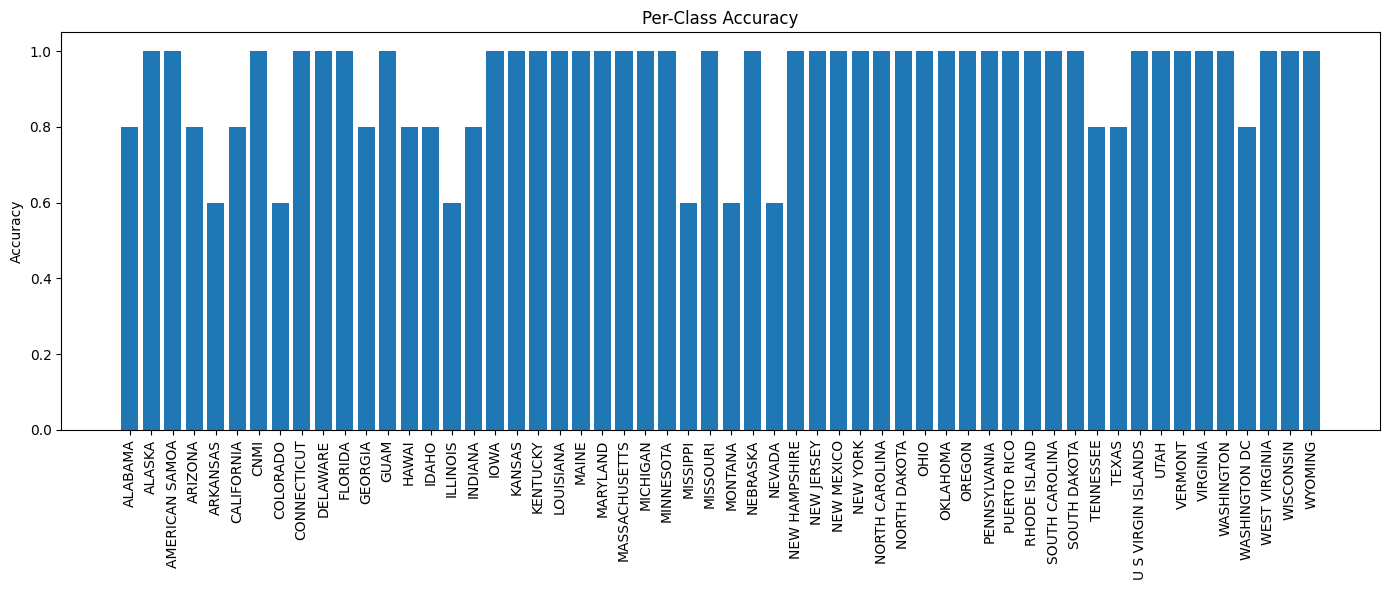

In [ ]:
# per class accuracy
plt.figure(figsize=(14, 6))
plt.bar(range(len(accuracy_per_class)), accuracy_per_class)
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()
